In [67]:
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, window, count, from_unixtime
from pyspark.sql.types import ArrayType,StringType,IntegerType
from pymongo import MongoClient
from pyspark.sql.functions import col,count,udf,split,explode,expr,trim,mean,sum,stddev,first,max,min,desc,avg
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

In [5]:
packages = [
    'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1',
    'org.apache.kafka:kafka-clients:3.2.0',
    'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2'
]

spark = SparkSession.builder\
   .master("local")\
   .appName("kafka-example")\
   .config("spark.jars.packages", ",".join(packages))\
   .getOrCreate()

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c6b4b9bb-7d7e-4516-9a78-958494019c51;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.1 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2

### Reading from Mongo

In [7]:
import numpy as np
np.bool=np.bool_

In [76]:
mongo_params = {
    "uri": "mongodb://mongo:27017",
    "database": "bigdata",
    "collection": "users"
}

dataFrame = spark.read\
                 .format("mongo")\
                 .options(**mongo_params) \
                 .load()

In [11]:
df=dataFrame

In [78]:
dataFrame.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- email: string (nullable = true)
 |-- name: string (nullable = true)
 |-- password: string (nullable = true)
 |-- watched_history: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- current_time: timestamp (nullable = true)
 |    |    |-- video_id: string (nullable = true)



### Description and counts of the data

In [13]:
# Check for null values in each column
for column in df.columns:
    print(f"Missing values in {column}: ", df.filter(df[column].isNull()).count())

# Drop rows with any null values (if appropriate)
df = df.na.drop()


Missing values in _id:  0
Missing values in categoryId:  0
Missing values in channelId:  0
Missing values in channelTitle:  0
Missing values in comment_count:  0
Missing values in comments_disabled:  0
Missing values in description:  0
Missing values in dislikes:  0
Missing values in likes:  0
Missing values in publishedAt:  0
Missing values in ratings_disabled:  0
Missing values in tags:  0
Missing values in thumbnail_link:  0
Missing values in title:  0
Missing values in trending_date:  0
Missing values in video_id:  0
Missing values in view_count:  0


In [18]:
df.groupby('video_id').count().toPandas()

,video_id,count
0,3bC2T0oFwoo,1
1,jTMJK7wb0rM,6
2,pPajUA64b0o,4
3,37XLHvZgU4Q,5
4,7j1BwoZF7zI,3
...,...,...
47137,8Ou7w3Sxk5E,7
47138,1NGa_Xt77xU,6
47139,_oYSiPBUuC8,8
47140,GZIIcp7qH0w,7


#### Creating a filtered data

In [38]:
filtered_data=dataFrame.select("video_id","view_count","channelTitle","title","view_count","comment_count","dislikes","likes","tags","categoryId")
filtered_data.limit(2).toPandas()

,video_id,view_count,channelTitle,title,view_count,comment_count,dislikes,likes,tags,categoryId
0,3C66w5Z0ixs,1514614,Brawadis,I ASKED HER TO BE MY GIRLFRIEND...,1514614,35313,5855,156908,brawadis|prank|basketball|skits|ghost|funny vi...,22
1,M9Pmf9AB4Mo,2381688,Apex Legends,Apex Legends | Stories from the Outlands – “Th...,2381688,16549,2794,146739,Apex Legends|Apex Legends characters|new Apex ...,20


# calculating average

In [35]:
mean_data=filtered_data.groupby("video_id").agg(first("channelTitle").alias("channelTitle"),first("title").alias("title"),
                                    mean("view_count").alias("avg_view"),mean("comment_count").alias("avg_comment_count"),mean("likes").alias("avg_likes"),
                                    mean("dislikes").alias("avg_dislikes"))
mean_data.toPandas()

,video_id,channelTitle,title,avg_view,avg_comment_count,avg_likes,avg_dislikes
0,--14w5SOEUs,MigosVEVO,Migos - Avalanche,4.554291e+06,14954.300000,220407.100000,3003.500000
1,--2O86Z0hsM,jf.okay,MY TESLA PAYS FOR ITSELF,5.077188e+05,1378.000000,16894.500000,0.000000
2,--40TEbZ9Is,Television Academy,Supporting Actress in a Comedy: 73rd Emmys,6.217304e+05,677.800000,7341.000000,347.200000
3,--47FjCWgrU,NFL,San Francisco 49ers vs. Arizona Cardinals Game...,1.838618e+06,1962.142857,21889.714286,0.000000
4,--5-brQiQFg,NFL,Washington Commanders vs. San Francisco 49ers ...,1.280997e+06,2078.000000,14603.000000,0.000000
...,...,...,...,...,...,...,...
47137,zzd4ydafGR0,Lil Tjay,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,8.639178e+06,50808.200000,596585.300000,5665.100000
47138,zziBybeSAtw,NBA,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,2.441650e+06,2803.500000,19471.500000,952.000000
47139,zzk09ESX7e0,MAMAMOO,[MV] 마마무 (MAMAMOO) - Where Are We Now,6.747998e+06,66977.071429,485103.428571,2665.642857
47140,zzsIqPVv2Q4,MaxCraft,I Survived 100 DAYS as a SLIME in HARDCORE Min...,2.623980e+06,1918.000000,63686.400000,0.000000


#### Max values and min values

In [79]:
max_data=filtered_data.groupby("video_id").agg(first("channelTitle").alias("channelTitle"),first("title").alias("title"),first('tags').alias('tags'),first("categoryId").alias("categoryId"),
                                    max("view_count").alias("max_view"),max("comment_count").alias("max_comment_count"),max("likes").alias("max_likes"),
                                    max("dislikes").alias("max_dislikes"))
max_data_pd=max_data.toPandas()
max_data_pd

,video_id,channelTitle,title,tags,categoryId,max_view,max_comment_count,max_likes,max_dislikes
0,--14w5SOEUs,MigosVEVO,Migos - Avalanche,Migos|Avalanche|Quality|Control|Music/Motown|R...,10,6823249,16445,262692,4107
1,--2O86Z0hsM,jf.okay,MY TESLA PAYS FOR ITSELF,[None],24,538485,1439,17290,0
2,--40TEbZ9Is,Television Academy,Supporting Actress in a Comedy: 73rd Emmys,[None],24,682609,723,8029,369
3,--47FjCWgrU,NFL,San Francisco 49ers vs. Arizona Cardinals Game...,[None],17,1940781,2018,22612,0
4,--5-brQiQFg,NFL,Washington Commanders vs. San Francisco 49ers ...,[None],17,1280997,2078,14603,0
...,...,...,...,...,...,...,...,...,...
47137,zzd4ydafGR0,Lil Tjay,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,Lil Tjay|Steady Calling My Phone|Calling My Ph...,10,13974461,57012,728439,7579
47138,zziBybeSAtw,NBA,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,NBA|G League|Basketball|game-0022000187|Lakers...,17,2598512,2872,20024,989
47139,zzk09ESX7e0,MAMAMOO,[MV] 마마무 (MAMAMOO) - Where Are We Now,MAMAMOO|마마무|WAW|마마무 WAW|MAMAMOO WAW|Where Are ...,10,9389223,77267,584431,3403
47140,zzsIqPVv2Q4,MaxCraft,I Survived 100 DAYS as a SLIME in HARDCORE Min...,maxcraft|minecraft maxcraft|100 days minecraft...,20,3079200,2061,70776,0


In [80]:
min_data=filtered_data.groupby("video_id").agg(first("channelTitle").alias("channelTitle"),first("title").alias("title"),
                                    min("view_count").alias("min_view"),min("comment_count").alias("min_comment_count"),min("likes").alias("min_likes"),
                                    min("dislikes").alias("min_dislikes"))
min_data_pd=min_data.toPandas()
min_data

DataFrame[video_id: string, channelTitle: string, title: string, min_view: int, min_comment_count: int, min_likes: int, min_dislikes: int]

### Analysis on maxData

In [58]:
split_tags=max_data.select(explode(split("tags", "\|")).alias('tags'))

In [59]:
split_tags.toPandas()

,tags
0,Migos
1,Avalanche
2,Quality
3,Control
4,Music/Motown
...,...
759041,kurtis conner
759042,commentary
759043,movie review
759044,alpha


#### Counting tags

In [70]:
split_tags.groupby('tags').count().orderBy(desc('count')).limit(30).toPandas()

,tags,count
0,[None],7885
1,funny,2634
2,comedy,1660
3,minecraft,1554
4,challenge,1090
5,gaming,893
6,vlog,890
7,news,764
8,NBA,720
9,highlights,693


#### Groupby count on catagoryID

In [69]:
# Calculate average metrics per category
avg_metrics = max_data.groupBy("categoryId").agg(
    avg("max_view").alias("average_views"),
    avg("max_likes").alias("average_likes"),
    avg("max_dislikes").alias("average_dislikes"),
    avg("max_comment_count").alias("average_comments")
)
avg_metrics.toPandas()


,categoryId,average_views,average_likes,average_dislikes,average_comments
0,28,2.969890e+06,103317.020365,1266.199438,5557.415730
1,26,1.507830e+06,71262.598031,1176.205086,4730.348646
2,27,1.976091e+06,101153.185817,816.350090,5674.681329
3,22,1.979907e+06,103214.559020,1511.517941,6167.180153
4,1,3.080671e+06,108753.761697,706.958651,7348.999456
5,20,1.744761e+06,84771.808923,760.171047,6033.534972
6,19,1.142784e+06,53329.380137,400.287671,2834.780822
7,15,1.638842e+06,58450.423077,413.403846,3593.163462
8,17,1.674047e+06,35547.664086,450.511203,3170.060132
9,23,1.744120e+06,118135.261661,979.689916,5775.930253


In [72]:
category_video_count=max_data.groupBy("categoryId").count()
category_video_count.toPandas()

,categoryId,count
0,28,1424
1,26,1219
2,27,1114
3,22,4041
4,1,1838
5,20,9436
6,19,292
7,15,208
8,17,6070
9,23,2251


In [74]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 27.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.6 MB/s eta 0:00:00


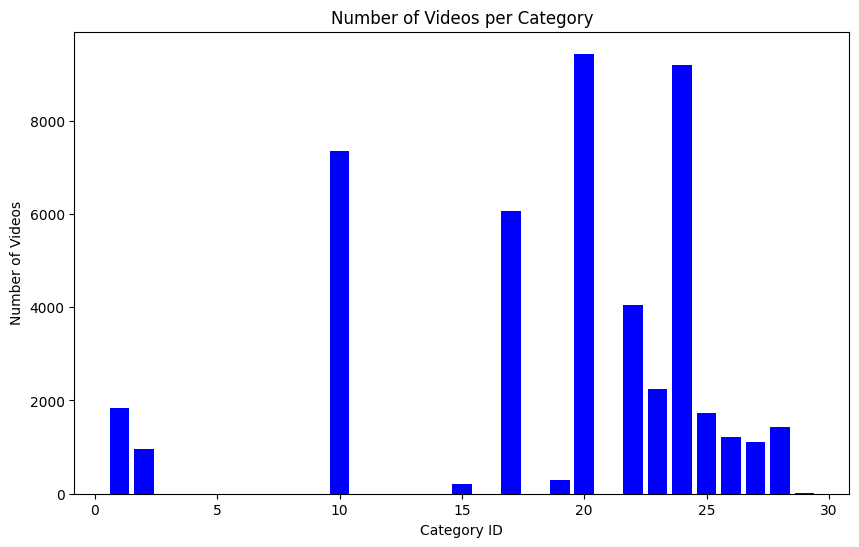

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
pd_df = category_video_count.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pd_df['categoryId'], pd_df['count'], color='blue')
plt.xlabel('Category ID')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Category')
plt.show()


### Reading from Kafka

In [3]:
kafka_params = {
    "kafka.bootstrap.servers": "kafka:9092",
    "subscribe": "VID_OPEN_TOPIC",
    "startingOffsets": "earliest",
    "endingOffsets": "latest"
}

# Read data from Kafka
raw_data = spark \
    .read \
    .format("kafka") \
    .options(**kafka_params) \
    .load()

In [4]:
# schema = "user_id STRING, video_id STRING, watched_at TIMESTAMP"
# schema = "user_id STRING, video_id STRING, timestamp TIMESTAMP"
schema = StructType([
    StructField("user_id", StringType(), False),
    StructField("video_id", StringType(), False),
    StructField("timestamp", TimestampType(), False)
])

In [5]:
# Assuming 'value' is the column containing the JSON data
parsed_data = raw_data\
    .select(from_json(col("value").cast("string"), schema).alias("data"))\
    .select("data.timestamp", "data.video_id")\
    .groupBy("video_id").count()\
    .orderBy(col("count").desc()).limit(10)

top_videos = parsed_data.toJSON().collect()

#### Sample value in `VID_OPEN_TOPIC` Kafka Topic
`{"timestamp": 1715268711.870222, "video_id": "QdBZY2fkU-0", "email": "allenA"}`

In [6]:
parsed_vids = []

for v in top_videos:
    parsed_vids.append(json.loads(v))

In [7]:
# Connect to MongoDB
client = MongoClient("mongodb://mongo:27017/")
db = client["bigdata"]
collection = db["trending_videos"]

In [8]:
collection.delete_many({})

for vid in parsed_vids:
    collection.insert_one(vid)

#### Sampling value in VID_SKIP_TIME_TOPIC in kafka

`{'timestamp': '2024-05-09 16:41:55.005352', 'video_id': 'tnTPaLOaHz8', 'email': 'km6133@nyu.edu', 'current_time': 225}`

In [17]:
kafka_params_skip_time = {
    "kafka.bootstrap.servers": "kafka:9092",
    "subscribe": "VID_SKIP_TIME_TOPIC",
    "startingOffsets": "earliest",
    "endingOffsets": "latest"
}

# Read data from Kafka
raw_data = spark \
    .read \
    .format("kafka") \
    .options(**kafka_params_skip_time) \
    .load()

In [51]:
schema_read_skip_time = StructType([
    StructField("user_id", StringType(), False),
    StructField("video_id", StringType(), False),
    StructField("timestamp", TimestampType(), False),
    StructField("current_time", IntegerType(), False),
    StructField("low_time",IntegerType(),False),
    StructField("high_time",IntegerType(),False)
])

In [52]:
parsed_data_skip_time = raw_data\
    .select(from_json(col("value").cast("string"), schema_read_skip_time).alias("data"))\
    .select("data.timestamp", "data.video_id","data.current_time")\
    .groupBy("video_id").agg(mean("current_time").alias("famous_segment"))\
    .limit(10)

skipped_videos = parsed_data_skip_time.toJSON().collect()

In [53]:
skipped_videos

['{"video_id":"tnTPaLOaHz8","famous_segment":318.0204081632653}']

In [23]:
getting_data=[]

for i in skipped_videos:
    getting_data.append(json.loads(i))
    

In [24]:
client = MongoClient("mongodb://mongo:27017/")
db = client["bigdata"]
collection = db["most_watched_segment"]

In [26]:
collection.delete_many({})
collection.insert_many(getting_data)

InsertManyResult([ObjectId('663d3a2524782295a6aead90')], acknowledged=True)